In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import numpy as np

In [0]:
train = pd.read_csv('~/personal/ai/projects/titanic/train.csv')
test = pd.read_csv('~/personal/ai/projects/titanic/test.csv')

In [500]:
train.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

In [501]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [502]:
train.describe()

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000         NaN    0.000000   
50%     446.000000    0.000000    3.000000         NaN    0.000000   
75%     668.500000    1.000000    3.000000         NaN    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

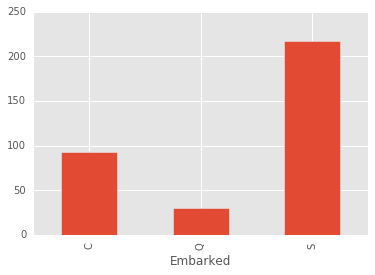

In [503]:
train.groupby(['Embarked']).sum()['Survived'].plot(kind='bar')

## Data Cleaning

Alright, lets work through this systematically.

### PassengerID

Dropping, doesn't look to be useful.

In [504]:
train = train.drop('PassengerId', axis=1)

### Pclass

No empty values. It looks like there's definitely a relationship between Pclass and Survived. Not much else to do here.

In [505]:
test['Pclass'].isnull().sum()

0

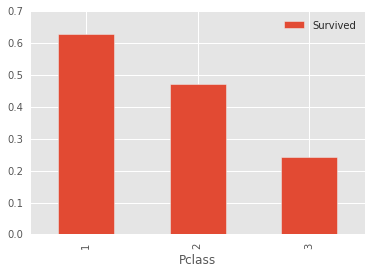

In [506]:
train[['Pclass', 'Survived']].groupby('Pclass').mean().plot.bar()

In [507]:
train['Pclass'] = train['Pclass'].astype(float)
test['Pclass'] = test['Pclass'].astype(float)

### Name

Call me irresponsible, but I'm going to drop Name because I don't have any experience with non-numeric data. I think that the standard approach is to make a new column for every unique name, but that would seem strange here since most people will have unique names. Also, the family variable will capture relaionships between people I imagine. I saw that someone used title in their script, but that would feel a bit like cheating.

In [508]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

### Gender

It looks like females faired pretty well compared to males.

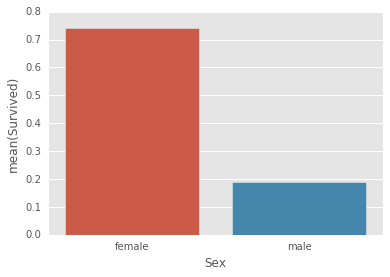

In [509]:

sex_percentage = train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot(x='Sex', y='Survived', data=sex_percentage)


In [510]:
dummies_train = pd.get_dummies(train['Sex'])
dummies_test = pd.get_dummies(test['Sex'])

train = train.drop('Sex', axis=1)
test = test.drop('Sex', axis=1)

train = train.join(dummies_train)
test = test.join(dummies_test)

### Age

Age is missing some values, let's see if I can figure out how to fill them. I will take the mean and standard deviation of age, and then select random ages within one standard deviation of the mean and fill them in.

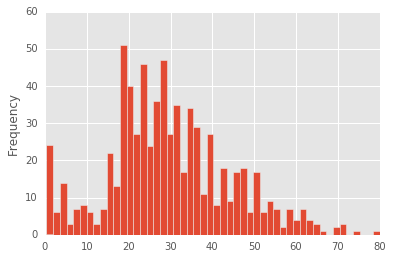

In [511]:
train['Age'].plot(kind='hist', bins=50)

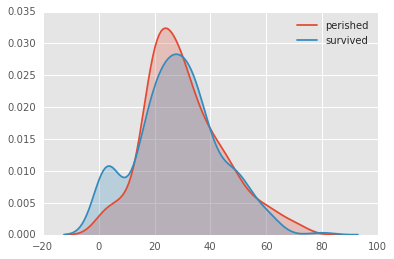

In [512]:
perished = train[train['Survived'] == 0]['Age']
survived = train[train['Survived'] == 1]['Age']

sns.kdeplot(perished, shade=True, label='perished')
sns.kdeplot(survived, shade=True, label='survived')


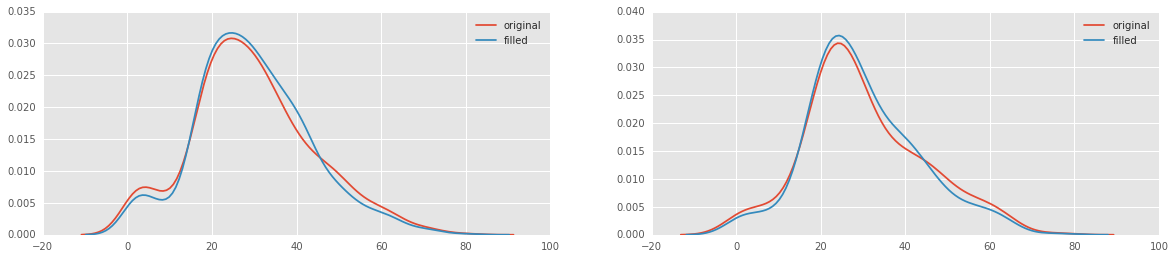

0


/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [513]:

mu_train = train['Age'].mean()
sigma_train = train['Age'].std()
missing_train = train['Age'].isnull().sum()

mu_test = test['Age'].mean()
sigma_test = test['Age'].std()
missing_test = test['Age'].isnull().sum()

fill_train = np.random.randint(mu_train - sigma_train, mu_train + sigma_train, size=missing_train)
fill_test = np.random.randint(mu_test - sigma_test, mu_test + sigma_test, size=missing_test)

train_copy = train.copy()
test_copy = test.copy()

train_copy['Age'][train_copy['Age'].isnull()] = fill_train
test_copy['Age'][test_copy['Age'].isnull()] = fill_test

print(train_copy['Age'].isnull().sum())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.kdeplot(train['Age'], label='original', ax=ax1)
sns.kdeplot(train_copy['Age'], label='filled', ax=ax1)

sns.kdeplot(test['Age'], label='original', ax=ax2)
sns.kdeplot(test_copy['Age'], label='filled', ax=ax2)


In [514]:
train_copy['Age'].isnull().sum()
test_copy['Age'].isnull().sum()

0

In [515]:
train = train_copy
test = test_copy

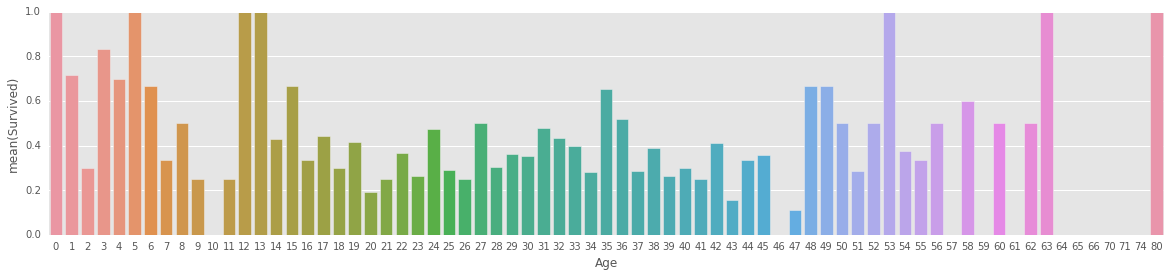

In [516]:
fig, axis1 = plt.subplots(1,1, figsize=(20,4))
age_df = pd.DataFrame(train['Age'].astype(int), train['Survived'], columns=['Age', 'Survived'])
average_age = train[['Age', 'Survived']].astype(int).groupby('Age', as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

### SibSp and Parch

Combining these columns by adding them together.

In [517]:
train['Family'] = train['SibSp'].astype(float) + train['Parch'].astype(float)
train = train.drop(['SibSp', 'Parch'], axis=1)

In [518]:
test['Family'] = test['SibSp'].astype(float) + test['Parch'].astype(float)
test = test.drop(['SibSp', 'Parch'], axis=1)

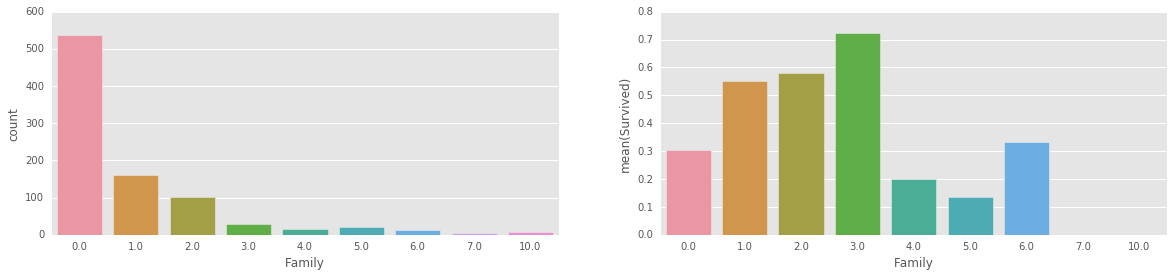

In [519]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.countplot(x='Family', data=train, ax=ax1)
sns.barplot(x='Family', y='Survived', data=train[['Family', 'Survived']].groupby('Family', as_index=False).mean(), ax=ax2)

### Ticket

Dropping, doesn't seem very useful.

In [520]:
train = train.drop('Ticket', axis=1)
test = test.drop('Ticket', axis=1)

### Fare

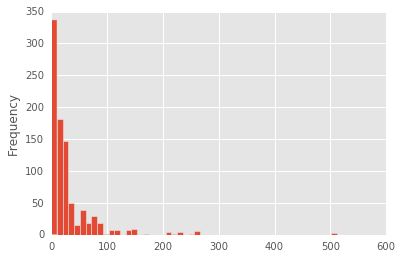

In [521]:
train['Fare'].plot.hist(bins=50)

In [522]:
print('Missing training fares: {}'.format(train['Fare'].isnull().sum()))
print('Missing test fares: {}'.format(test['Fare'].isnull().sum()))

Missing training fares: 0
Missing test fares: 1


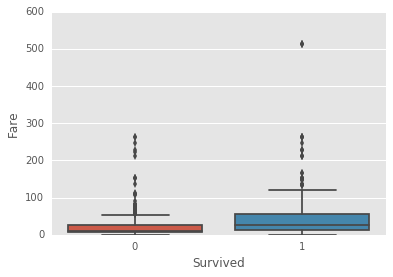

In [523]:
sns.boxplot(x='Survived', y='Fare', data=train)

The data is highly skewed, I'm going to fill the missing test value as the median of all test fares.

In [524]:
median = test['Fare'].median()
test['Fare'] = test['Fare'].fillna(median)

### Cabin

Dropping Cabin right off the bat because it has so many missing values.

In [525]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

### Embarked

In [526]:
print('Missing training Embarked: {}'.format(train['Embarked'].isnull().sum()))
print('Missing test Embarked: {}'.format(test['Embarked'].isnull().sum()))


Missing training Embarked: 2
Missing test Embarked: 0


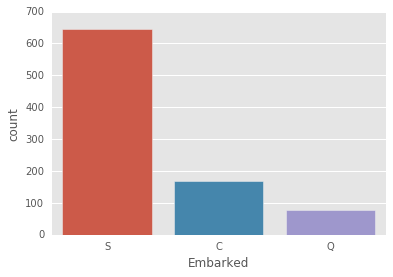

In [527]:
sns.countplot(x='Embarked', data=train)

Filling with "S", which is the most common value.

In [528]:
train['Embarked'] = train['Embarked'].fillna('S')

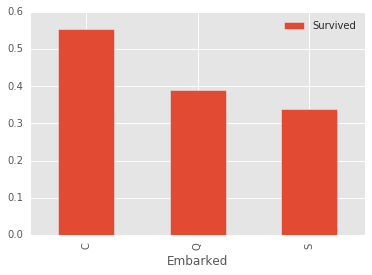

In [529]:
train[['Embarked', 'Survived']].groupby('Embarked').mean().plot.bar()

In [530]:
embarked_dummies_train = pd.get_dummies(train['Embarked'])
embarked_dummies_test = pd.get_dummies(test['Embarked'])

In [531]:
train = train.drop('Embarked', axis=1)
test = test.drop('Embarked', axis=1)

In [532]:
train = train.join(embarked_dummies_train)
test = test.join(embarked_dummies_test)

# Prediction

The data is ready, and everything is converted to float. Seems like random forests are the way to go based on the tutorials.

## Random Forests

Random forests are a type of averaging ensemble method. The idea is to add randomization to the construction of a predictor, and then average the results. This helps by reducing variance.

Random forests are a perturb and combine techinique.

### OK, but what does all of this really mean?

I decided to resort to [metacademy](https://metacademy.org/graphs/concepts/random_forests#focus=adxqdwpb&mode=explore) in order to gain some traction. After looking at the graph, I decided that I should probably backtrack and figure out what decision trees are in more depth.

### Decision Trees

[Decision trees](https://metacademy.org/graphs/concepts/random_forests#focus=decision_trees&mode=learn) lead me to The Elements of Statistical Learning 9.2.

We can conceptualize what decision trees do in 3D. Imagine X1 and X2 are our first two dimensions, and Y is our height dimension. We want to partition the X1, X2 plane into rectangles recursively. We do this by constructing a tree that uses thresholds to classify a particular sample. We check the threshold against a particular feature of our sample at every node, and go in the direction specified by the decision recursively until we reach a terminal node. The node we end up at has a constant multiplier associated with it, which specifies the prediction Y for our input sample. Y is referred to as a response variable. A visual representation makes all of the difference, I recommend referring to the book this is unclear.

#### Regression Trees

Use cost-complexity pruning governed by a parameter alpha to find the optimal balance of goodness-of-fit to computational complexity (size of tree).

Cost function is squared error between actual y for a region and the value of the estimates in that region. that also takes into account the number of terminal nodes (a form of regularization it seems).

Build a tree to a certain depth, and then prune by weakest-link pruning. This means iteratively find the internal node in the tree that provides the smallest increase in goodness of fit and collapse it until we are left with just the root node. The optimal balance of fit and computation is provably in that ancestry.

#### Classification Trees

Basically the same as regression trees, but the cost function is no longer greedy least squares optimization.

There are several ways of classifying errors, but the three stated are:

1. Misclassification error
2. Gini Index
3. Cross-entropy or deviance

Gini Index and Cross-entropy are used during the construction of the tree, because they are more sensitive to changes in node probility than the misclassification rate.

For cost-complexity pruning, the cost measure used is generally misclassification.

#### Categorical Predictors

Unordered categories q can have $2^{q-1} - 1$ possible splits of the data into two. This quickly becomes intractible with large q. However, it is possible to treat the categories as if they were ordered. The text referrs to a 0-1 outcome which sounds vaguely similar to one-vs-all.

#### Loss Matrix

Some misclassifications are more costly than others. Therefore, a loss matrix assigns weight to each sort of misclassification. It is ${\rm I\!R}^{K x K}$ in dimension where K is the number of classes.

#### Missing Predictor Values

There are two standard options in general when predictor values are missing.

1. Drop the observation altogether.
2. Impute the missing value based the mean of the feature.

With trees, there are actually better options (this doesn't bode well for much of the work that I did in cleaning the data in this project):

1. Add a missing category.
2. Use surrogate predictors. This basically means that if an observation is lacking a feature needed for the primary predictor, instead use the surrogate the best mimics the primary predictor but can be used in the face of the missing feature.	

#### Why binary splits?

It turns out that splits of degree greater than 2 are actually not good because it fragments the data too quickly as it traverses down the tree.

#### Instability of Trees

Trees are inherently very high in variance. A small change in the data can result in a much different tree. This is due to trying to reduce the complexity of the data into a tree. That's where bagging comes in, which will average over many trees to reduce this variance.

#### Lack of smoothness

This can be seen more easily graphically, but CART can be addressed by MARS apparently.

#### Trees cannot capture additive structure

The output should sometimes be from two features added together e.g. $Y = c_1I(X_1 < t_1) + c_2I(X_2 < t_2) + \epsilon$






In [533]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null float64
Age         891 non-null float64
Fare        891 non-null float64
female      891 non-null float64
male        891 non-null float64
Family      891 non-null float64
C           891 non-null float64
Q           891 non-null float64
S           891 non-null float64
dtypes: float64(9), int64(1)
memory usage: 69.7 KB


In [669]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_final = test.drop('PassengerId', axis=1)

In [568]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

10

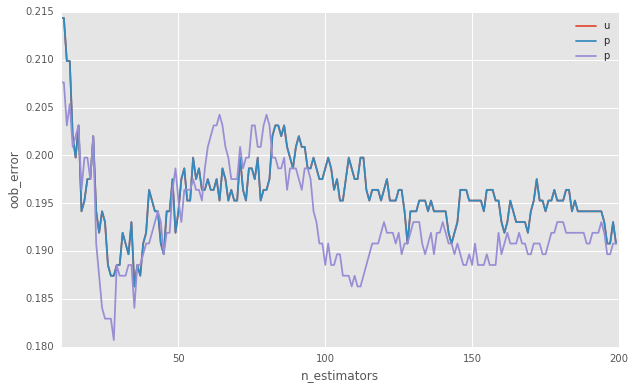

In [610]:
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train, y_train)

from collections import OrderedDict

import random

RANDOM_STATE = 13

min_estimators, max_estimators = 10, 200
n_estimators = np.array([i for i in range(min_estimators, max_estimators)])

ensemble_clfs = [
	("RandomForestClassifier, max_features='sqrt'",
	 RandomForestClassifier(warm_start=True, oob_score=True,
	 max_features="sqrt", random_state=RANDOM_STATE)),
	("RandomForestClassifier, max_features='log2'",
	 RandomForestClassifier(warm_start=True, oob_score=True,
	 max_features="auto", random_state=RANDOM_STATE)),
	("RandomForestClassifier, max_features='n'",
	 RandomForestClassifier(warm_start=True, oob_score=True,
	 max_features=len(X_train.columns), random_state=RANDOM_STATE)),
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

for label, clf in ensemble_clfs:
	for i in n_estimators:
		clf.set_params(n_estimators=i)
		clf.fit(X_train, y_train)
		oob_error = 1 - clf.oob_score_
		error_rate[label].append((i, oob_error))


for label, clf_err in error_rate.items():
	xs, ys = zip(*clf_err)
	plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("oob_error")
plt.legend("upper right")

fig = plt.gcf()
fig.set_size_inches(10,6)
plt.show()



In [576]:
prediction = grid.predict(X_final)

0.80158730158730163

In [612]:
clf = ensemble_clfs[0][1]
clf.score(X_train, y_train)

0.9854096520763187

In [577]:
# output = test.join(pd.DataFrame(prediction, columns=['Survived']))
# output[['PassengerId', 'Survived']].to_csv('~/personal/ai/projects/titanic/predictions.csv', sep=',', index=False)

## Logistic Regression

I'm seeing a score of 0.76555 against the test data. Not so hot. Let's see if logistic regression can do any better.

In [650]:
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import validation_curve

np.random.seed(0)
indicies = np.arange(y_train.shape[0])
np.random.shuffle(indicies)
X_shuffle, y_shuffle = X_train.iloc[indicies], y_train.iloc[indicies]
sample_range = np.logspace(-7, 8, 20)
train_scores, test_scores = validation_curve(LogisticRegression(), X_shuffle, y_shuffle, "C", sample_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


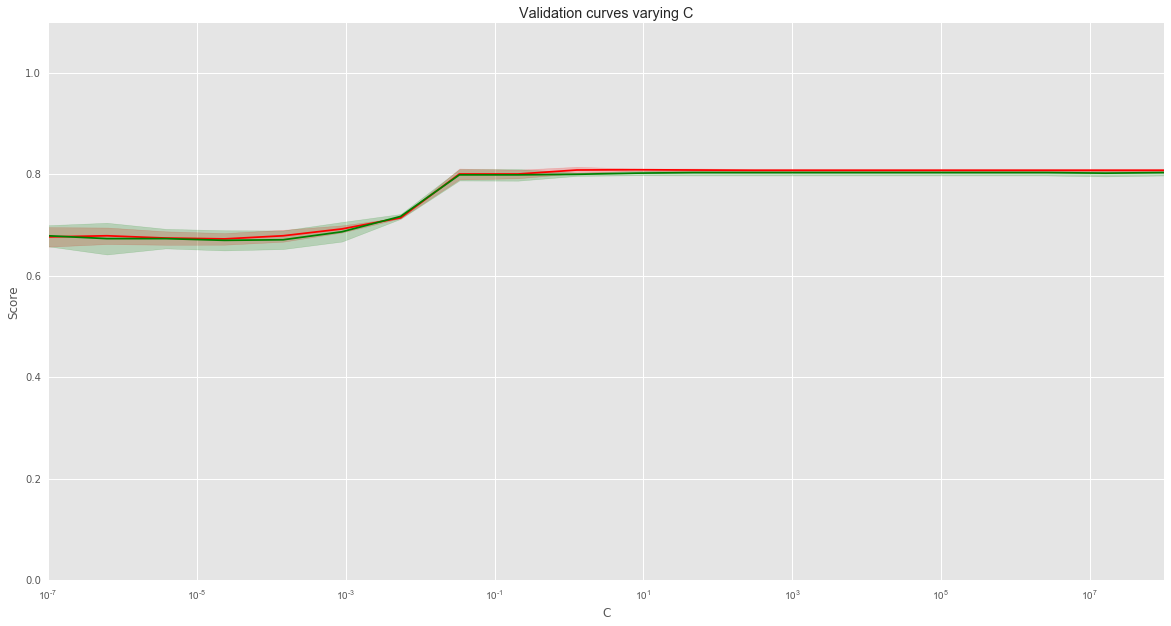

In [651]:

fig = plt.gcf()
plt.title('Validation curves varying C')
plt.xlabel('C')
plt.ylabel('Score')

fig.set_size_inches(20, 10)
plt.ylim(0,1.1)
plt.semilogx(sample_range, train_scores_mean, label="train scores", color='r')
plt.fill_between(sample_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.semilogx(sample_range, test_scores_mean, label="test scores", color='g')
plt.fill_between(sample_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='g')

## Learning Curves



In [676]:
from sklearn import preprocessing

X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

In [677]:
X_train_scaled, X_cv_scaled, y_train, y_cv = cross_validation.train_test_split(X_train_scaled, y_train)

clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [679]:
logreg.score(X_train_scaled, y_train)

0.73203592814371254

In [680]:
logreg.score(X_cv_scaled, y_cv)

0.77578475336322872

In [666]:
logreg_prediction = logreg.predict(X_final)

In [667]:
output = test.join(pd.DataFrame(logreg_prediction, columns=['Survived']))
output[['PassengerId', 'Survived']].to_csv('~/personal/ai/projects/titanic/logreg_predictions.csv', sep=',', index=False)

### Feature Scaling / Mean Normalization